In [1]:
import pandas as pd
import sklearn
import numpy as np
import util
import seaborn as sns
import matplotlib.pyplot as plt
import shap
import seaborn as sns

In [2]:
from sklearn.linear_model import LinearRegression, RidgeCV
import statsmodels.api as sm 
import matplotlib.pylab as plt 
from dmba import regressionSummary, exhaustive_search 
from dmba import adjusted_r2_score, AIC_score, BIC_score
from sklearn.metrics import r2_score
from dmba import backward_elimination, forward_selection
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import QuantileTransformer, quantile_transform

In [3]:
pd.set_option('max_columns', None)
pd.set_option('max_rows', 10)

In [4]:
ultimate_df = pd.read_csv('Data/Created Datasets/ALL_merge_truncate3.csv', index_col = 0)

In [5]:
ultimate_df.sort_values(by = 'TIME', inplace = True)
ultimate_df.set_index(ultimate_df['TIME'] , inplace = True)

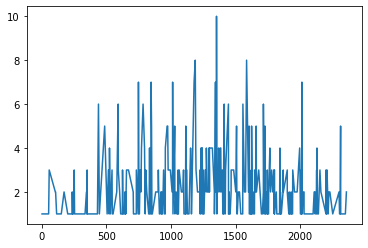

In [6]:
plt.plot(ultimate_df.index, ultimate_df['COUNT'])

In [7]:
ultimate_df['LIGHT'] = ultimate_df['LIGHT'].apply(util.lc)
ultimate_df['TRAFFCTL'] = ultimate_df['TRAFFCTL'].apply(util.tc)
ultimate_df['DRIVACT'] = ultimate_df['DRIVACT'].apply(util.actc)
ultimate_df['DRIVCOND'] = ultimate_df['DRIVCOND'].apply(util.condc)
ultimate_df['VEHTYPE'] = ultimate_df['VEHTYPE'].apply(util.vehc)
ultimate_df['INVAGE'] = ultimate_df['INVAGE'].apply(util.agec)
#ultimate_df['MANOEUVER'] = ultimate_df['MANOEUVER'].apply(util.manc)

In [8]:
ultimate_df = ultimate_df.replace('Yes', 1).replace('<Null>', 0).replace('<Null', 0)

In [9]:
ultimate_df['TIME'] = round(ultimate_df['TIME']/100,3)

In [10]:
X = ultimate_df[[col for col in ultimate_df.columns if col not in ('COUNT', 'WARDNUM', 'LATITUDE', 'LONGITUDE', 'Latitude', 'Longitude', 'INVAGE', 'VEHTYPE')]]
X = pd.get_dummies(X, drop_first = True)
X = sm.add_constant(X)

Y = ultimate_df['COUNT']

In [11]:
model = sm.GLM(Y, X, family = sm.families.Poisson())
results = model.fit()

In [12]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  COUNT   No. Observations:                  706
Model:                            GLM   Df Residuals:                      662
Model Family:                 Poisson   Df Model:                           43
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1323.9
Date:                Wed, 02 Mar 2022   Deviance:                       694.66
Time:                        19:21:07   Pearson chi2:                     757.
No. Iterations:                     5   Pseudo R-squ. (CS):             0.2333
Covariance Type:            nonrobust                                         
=============================================================================================================
                                                coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------
const                                         0.9825      0.587      1.673      0.094      -0.169       2.134
IncidentsTotal                            -1.099e-05      0.000     -0.044      0.965      -0.000       0.000
SeverityScore                                 2.0015      1.437      1.392      0.164      -0.816       4.819
PercentOfVehicles                             1.0879      0.993      1.096      0.273      -0.858       3.034
AvgAcceleration                               0.2649      0.153      1.736      0.083      -0.034       0.564
TIME                                         -0.0070      0.004     -1.549      0.121      -0.016       0.002
RDSFCOND_Dry                                 -0.0233      0.279     -0.083      0.933      -0.570       0.524
RDSFCOND_Loose Snow                          -0.2116      0.344     -0.615      0.538      -0.886       0.463
RDSFCOND_Other                               -0.1641      0.383     -0.429      0.668      -0.914       0.586
RDSFCOND_Packed Snow                          0.3878      0.451      0.860      0.390      -0.496       1.271
RDSFCOND_Slush                               -0.4778      0.400     -1.194      0.233      -1.262       0.307
RDSFCOND_Wet                                 -0.0874      0.279     -0.313      0.754      -0.634       0.459
VISIBILITY_Clear                             -0.0833      0.278     -0.300      0.764      -0.628       0.462
VISIBILITY_Fog, Mist, Smoke, Dust            -0.4031      0.714     -0.565      0.572      -1.802       0.996
VISIBILITY_Freezing Rain                     -0.5616      0.544     -1.031      0.302      -1.629       0.506
VISIBILITY_Other                              0.3027      0.357      0.848      0.396      -0.397       1.002
VISIBILITY_Rain                               0.1266      0.282      0.449      0.654      -0.426       0.680
VISIBILITY_Snow                               0.0424      0.309      0.137      0.891      -0.562       0.647
LIGHT_Dark                                   -0.1166      0.070     -1.668      0.095      -0.254       0.020
LIGHT_Dawn                                    0.5143      0.287      1.793      0.073      -0.048       1.076
LIGHT_Daylight                               -0.0559      0.057     -0.979      0.327      -0.168       0.056
LIGHT_Dusk                                    0.2855      0.183      1.562      0.118      -0.073       0.644
TRAFFCTL_No Control                          -0.2046      0.241     -0.848      0.396      -0.677       0.268
TRAFFCTL_Pedestrian Crossover                -0.6002      0.427     -1.405      0.160      -1.437       0.237
TRAFFCTL_Stop/Yield Sign                     -0.2750      0.260     -1.057      0.290      -0.785       0.235
TRA

In [13]:
poisson_training_results = sm.GLM(Y, X, family=sm.families.Poisson()).fit()

In [14]:
poisson_predictions = poisson_training_results.get_prediction(X)
preds = poisson_predictions.summary_frame()['mean']

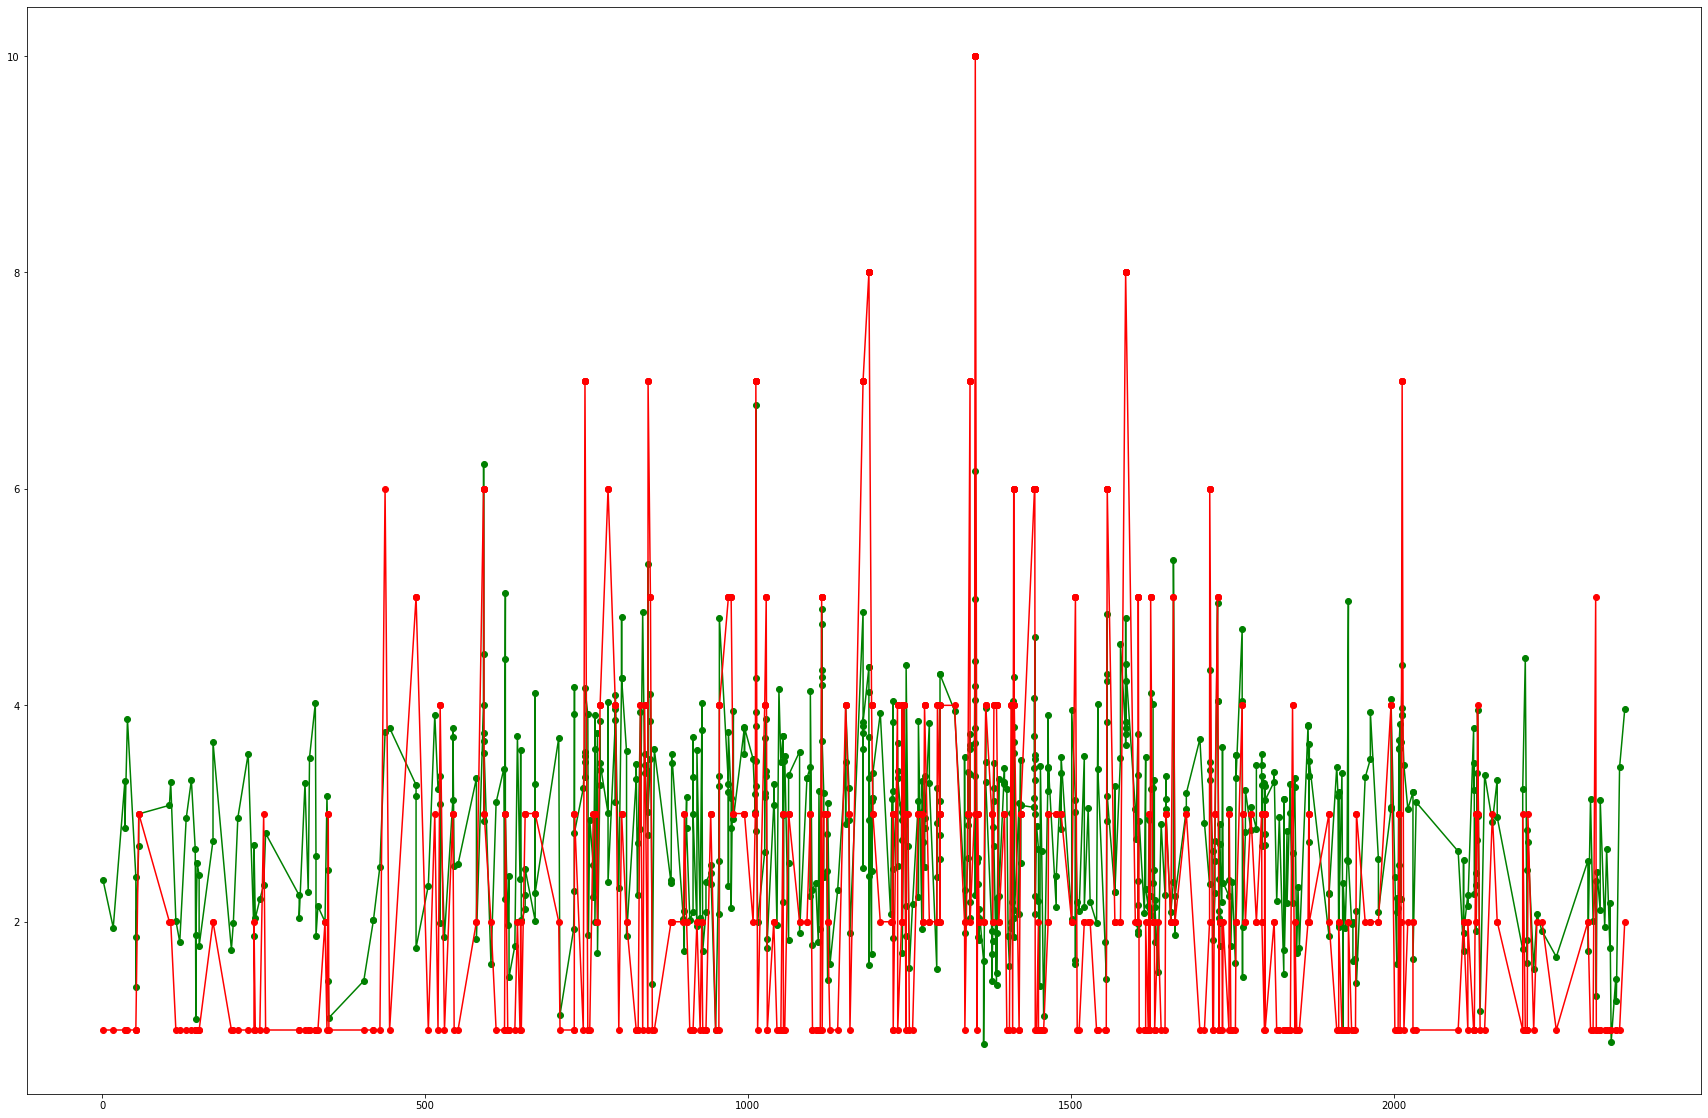

In [15]:
plt.figure(figsize = (30, 20))
predicted, = plt.plot(X.index, preds, 'go-', label='Predicted counts')
actual, = plt.plot(X.index, Y, 'ro-', label='Actual counts')
